In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")

print("Path to dataset files:", path)

100%|██████████| 5.32M/5.32M [00:00<00:00, 38.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rikdifos/credit-card-approval-prediction/versions/3


<font size=6 >Credit Card Approval Prediction Using Sklearn</font>

In [2]:
pip install imbalanced-learn

# Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE

# Load the Data

In [4]:

# Load the files
df_app = pd.read_csv(f"{path}/application_record.csv")
df_cr = pd.read_csv(f"{path}/credit_record.csv")

print("Application Record shape:", df_app.shape)
print("Credit Record shape:", df_cr.shape)


Application Record shape: (438557, 18)
Credit Record shape: (1048575, 3)


# Preview Data

In [5]:
df_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
df_cr.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Check for Missing Values

In [7]:
print(df_app.isnull().sum())
print(df_cr.isnull().sum())

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


# Drop rows with missing values

In [8]:
df_app.dropna(inplace=True)
df_cr.dropna(inplace=True)

# Derive Target from credit_record

In [9]:
df_cr['STATUS'] = pd.to_numeric(df_cr['STATUS'], errors='coerce')
df_status = df_cr.groupby('ID')['STATUS'].max().reset_index()
df_status.rename(columns={'STATUS': 'MAX_STATUS'}, inplace=True)
df_status['TARGET'] = df_status['MAX_STATUS'].apply(lambda x: 1 if x >= 2 else 0)
df_merged = pd.merge(df_app, df_status[['ID', 'TARGET']], on='ID', how='inner')
print("Merged shape:", df_merged.shape)

Merged shape: (25134, 19)


# Basic Feature Encoding & Scaling

In [10]:
categorical_cols = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]
for col in categorical_cols:
    if col in df_merged.columns:
        le = LabelEncoder()
        df_merged[col] = le.fit_transform(df_merged[col].astype(str))

numeric_cols = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS'
]
for col in numeric_cols:
    if col in df_merged.columns:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

scaler = StandardScaler()
for col in numeric_cols:
    if col in df_merged.columns:
        df_merged[col] = scaler.fit_transform(df_merged[[col]])

<ipython-input-10-a7a273c0ea74>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna(df_merged[col].median(), inplace=True)


# Train/Test Split

In [11]:
features_to_drop = ['ID', 'TARGET']
X = df_merged.drop(columns=features_to_drop)
y = df_merged['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("\nClass distribution in y_train:")
print(pd.Series(y_train).value_counts())

X_train shape: (20107, 17) X_test shape: (5027, 17)

Class distribution in y_train:
0    19769
1      338
Name: count, dtype: int64


# Handling Imbalance with SMOTE Oversampling

In [12]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE, new class distribution in y_train_res:")
print(pd.Series(y_train_res).value_counts())


After SMOTE, new class distribution in y_train_res:
0    19769
1    19769
Name: count, dtype: int64


# Baseline Random Forest on SMOTE Data
 - number of trees (n_estimators=10)
 - tree depth (max_depth=2)
 - min_samples_split (min_samples_split=10)


=== Intentionally Weak Baseline RF (SMOTE) Performance ===
Confusion Matrix:
[[3169 1774]
 [  42   42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      4943
           1       0.02      0.50      0.04        84

    accuracy                           0.64      5027
   macro avg       0.51      0.57      0.41      5027
weighted avg       0.97      0.64      0.77      5027



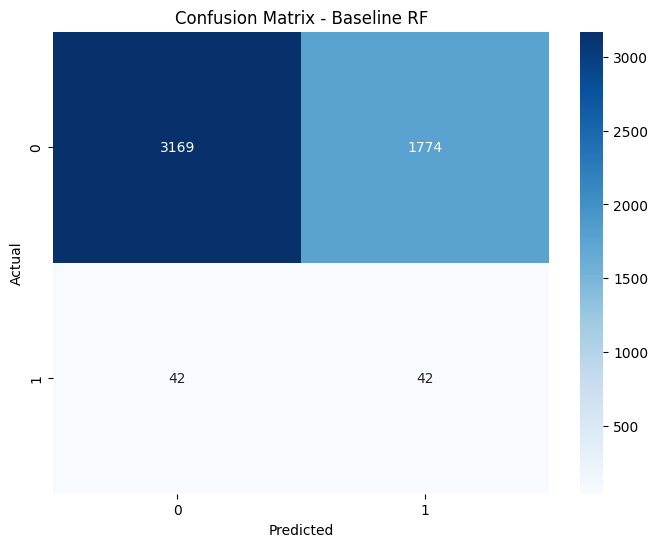

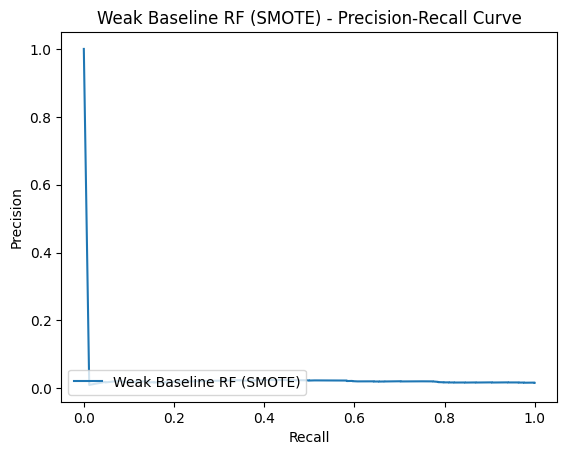

In [13]:
baseline_rf_bad = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=10,
    random_state=42
)
baseline_rf_bad.fit(X_train_res, y_train_res)

y_pred_bad = baseline_rf_bad.predict(X_test)
y_pred_bad_proba = baseline_rf_bad.predict_proba(X_test)[:, 1]

print("\n=== Intentionally Weak Baseline RF (SMOTE) Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bad))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bad))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_bad), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline RF')
plt.show()

# Plot Precision-Recall Curve for the weak baseline
prec_bad, rec_bad, _ = precision_recall_curve(y_test, y_pred_bad_proba)
plt.figure()
plt.plot(rec_bad, prec_bad, label="Weak Baseline RF (SMOTE)")
plt.title("Weak Baseline RF (SMOTE) - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Hyperparameter Tuning with SMOTE using RandomizedSearchCV (Optimizing for AUC)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters from RandomizedSearchCV (Optimizing for AUC): {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

=== Tuned RF (SMOTE, Optimized for AUC) Performance ===
Confusion Matrix:
[[4872   71]
 [  53   31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4943
           1       0.30      0.37      0.33        84

    accuracy                           0.98      5027
   macro avg       0.65      0.68      0.66      5027
weighted avg       0.98      0.98      0.98      5027



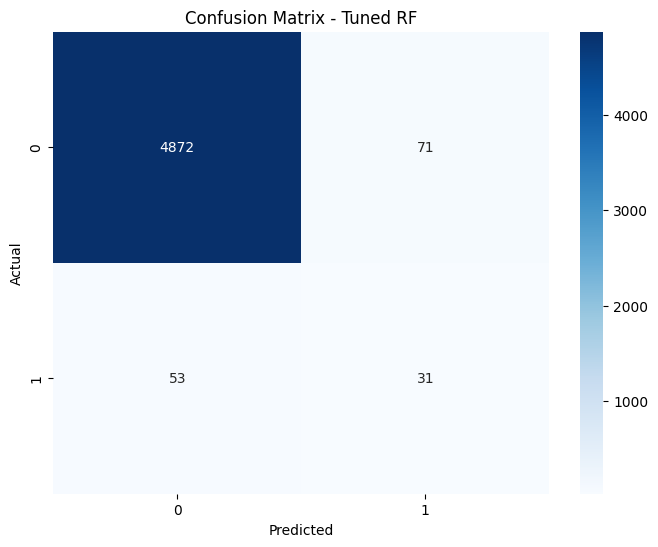

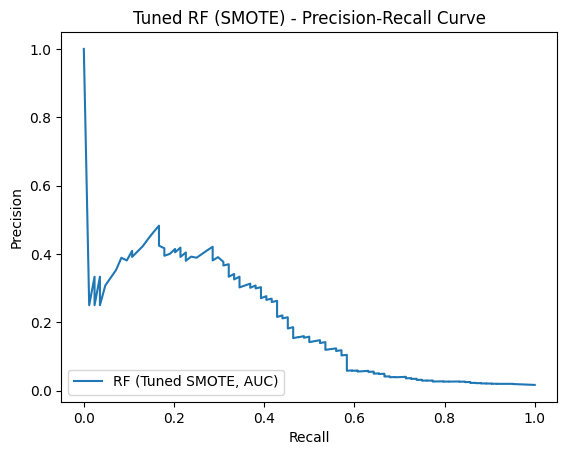

In [14]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    scoring='roc_auc',     # Optimize for AUC
    cv=3,
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train_res, y_train_res)

best_model_smote = random_search.best_estimator_
print("\nBest parameters from RandomizedSearchCV (Optimizing for AUC):", random_search.best_params_)

y_pred_tuned_smote = best_model_smote.predict(X_test)
y_pred_tuned_smote_proba = best_model_smote.predict_proba(X_test)[:, 1]

print("\n=== Tuned RF (SMOTE, Optimized for AUC) Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned_smote))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned_smote), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned RF')
plt.show()

# Plot Precision-Recall Curve for Tuned Model
prec_tuned_smote, rec_tuned_smote, _ = precision_recall_curve(y_test, y_pred_tuned_smote_proba)
plt.figure()
plt.plot(rec_tuned_smote, prec_tuned_smote, label="RF (Tuned SMOTE, AUC)")
plt.title("Tuned RF (SMOTE) - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Compare ROC Curves for Weak Baseline and Tuned Models

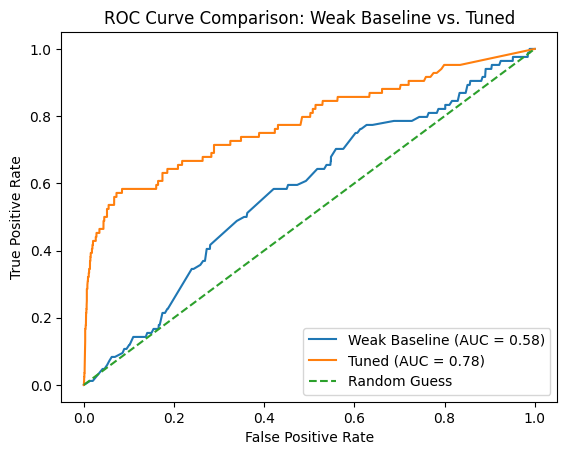


Comparison of Weak Baseline vs. Tuned Model:
Weak Baseline AUC: 0.577
Tuned AUC:         0.782


In [15]:
fpr_bad, tpr_bad, _ = roc_curve(y_test, y_pred_bad_proba)
roc_auc_bad = auc(fpr_bad, tpr_bad)

fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_tuned_smote_proba)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure()
plt.plot(fpr_bad, tpr_bad, label=f"Weak Baseline (AUC = {roc_auc_bad:.2f})")
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned (AUC = {roc_auc_tuned:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.title("ROC Curve Comparison: Weak Baseline vs. Tuned")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

print("\nComparison of Weak Baseline vs. Tuned Model:")
print(f"Weak Baseline AUC: {roc_auc_bad:.3f}")
print(f"Tuned AUC:         {roc_auc_tuned:.3f}")


=== Tuned RF (SMOTE, Optimized for AUC) Performance ===
Confusion Matrix:
[[4184  759]
 [  35   49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4943
           1       0.06      0.58      0.11        84

    accuracy                           0.84      5027
   macro avg       0.53      0.71      0.51      5027
weighted avg       0.98      0.84      0.90      5027



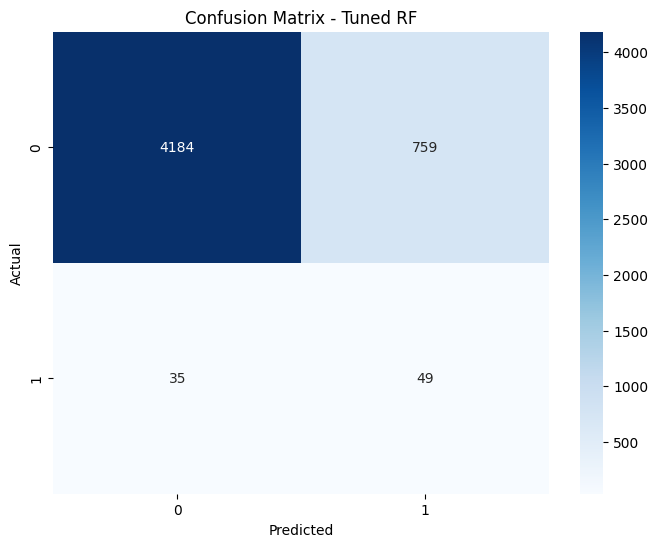

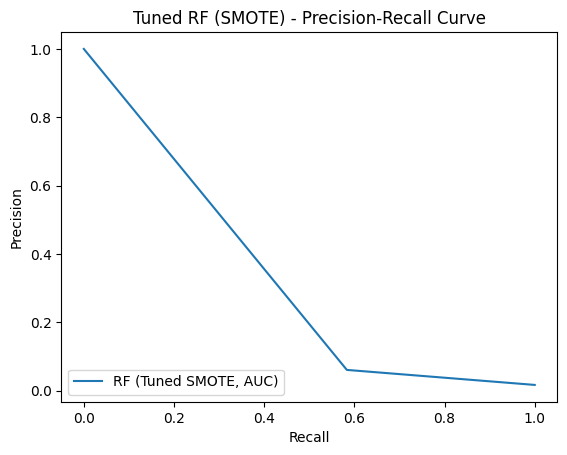

In [20]:
y_pred_tuned_smote = best_model_smote.predict(X_test)
y_pred_tuned_smote_proba = best_model_smote.predict_proba(X_test)[:, 1]

y_pred_custom = (y_pred_tuned_smote_proba >= 0.1).astype(int)

print("\n=== Tuned RF (SMOTE, Optimized for AUC) Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned RF')
plt.show()

# Plot Precision-Recall Curve for Tuned Model
prec_tuned_smote, rec_tuned_smote, _ = precision_recall_curve(y_test, y_pred_custom)
plt.figure()
plt.plot(rec_tuned_smote, prec_tuned_smote, label="RF (Tuned SMOTE, AUC)")
plt.title("Tuned RF (SMOTE) - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()